In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve 
import re
from sklearn.linear_model import LogisticRegression

In [0]:
titanic_data = pd.read_csv('https://raw.githubusercontent.com/shala2020/shala2020.github.io/master/Lecture_Materials/Assignments/MachineLearning/L2/titanic.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
titanic_data.shape

(891, 12)

In [0]:
y = titanic_data['Survived']
X = titanic_data.drop(['Survived'], axis = 1)

In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [0]:
X = X.drop(['PassengerId'], axis=1)
X= X.drop(['Ticket'], axis=1)
X= X.drop(['Name'], axis=1)

In [0]:
X['Cabin'] = X['Cabin'].fillna("U0")
X['Deck'] =  X['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
X['Deck'] =  X['Deck'].fillna(0)
X = X.drop(['Cabin'], axis=1)

In [0]:
X['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [0]:
X['Embarked'] = X['Embarked'].fillna('S')

In [0]:
mean = X["Age"].mean()
std = X["Age"].std()
is_null = X["Age"].isnull().sum()
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
age_slice = X["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
X["Age"] = age_slice
X["Age"] = X["Age"].astype(int)


In [0]:
X=X.apply(LabelEncoder().fit_transform)

In [0]:
X.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,2,1,22,1,0,18,2,8
1,0,0,38,1,0,207,0,2
2,2,0,26,0,0,41,2,8
3,0,0,35,1,0,189,2,2
4,2,1,35,0,0,43,2,8
5,2,1,42,0,0,51,1,8
6,0,1,54,0,0,186,2,4
7,2,1,2,3,1,124,2,8
8,2,0,27,0,2,74,2,8
9,1,0,14,1,0,154,0,8


#**Random Forest Classifier With 83% Test Accuracy**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=123)
 
rfc = RandomForestClassifier(n_estimators=16,
                            random_state=1111,
                            max_features=8)

rfc.fit(X_train, y_train)

print('The training error is {0:.3f}'.format(mean_absolute_error(y_train, rfc.predict(X_train))))
print('The testing error is {0:.3f}'.format(mean_absolute_error(y_test, rfc.predict(X_test))))

The training error is 0.025
The testing error is 0.166


In [0]:
predictions = rfc.predict(X_train)
accuracy = accuracy_score(y_train, predictions)
print(np.round(accuracy*100, 2), '%')
predictions = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(np.round(accuracy*100, 2), '%')
print(confusion_matrix(y_test, predictions))
print("="*60)
print(classification_report(y_test, predictions))

97.46 %
83.41 %
[[122  17]
 [ 20  64]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       139
           1       0.79      0.76      0.78        84

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



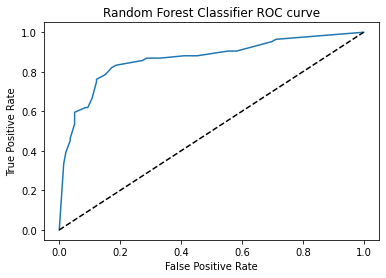

In [0]:
probs = rfc.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC curve')
plt.show()

#**XG Boost Classifier With 87% Test Accuracy**

In [0]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.3,n_estimators=180, max_depth=3)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
predictions = xgb_clf.predict(X_train)
# accuracy score
accuracy = accuracy_score(y_train, predictions)
print(np.round(accuracy*100, 2), '%')
predictions = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(np.round(accuracy*100, 2), '%')
print(confusion_matrix(y_test, predictions))
print("="*60)
print(classification_report(y_test, predictions))

94.01 %
87.0 %
[[128  11]
 [ 18  66]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       139
           1       0.86      0.79      0.82        84

    accuracy                           0.87       223
   macro avg       0.87      0.85      0.86       223
weighted avg       0.87      0.87      0.87       223



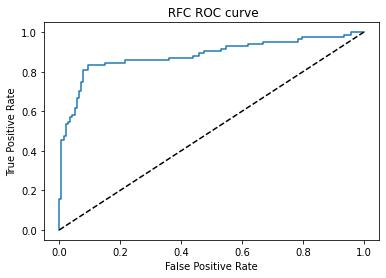

In [0]:
probs = xgb_clf.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' RFC ROC curve')
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(y_test, probs)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.8827509421034601


#**Gradient Boosting Classifier With 82% Test Accuracy**

In [0]:
clf = GradientBoostingClassifier(n_estimators=25, learning_rate=0.7, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.7, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=25,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
predictions = clf.predict(X_train)
accuracy = accuracy_score(y_train, predictions)
print(np.round(accuracy*100, 2), '%')
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(np.round(accuracy*100, 2), '%')
print(confusion_matrix(y_test, predictions))
print("="*60)
print(classification_report(y_test, predictions))

83.23 %
82.06 %
[[120  19]
 [ 21  63]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       139
           1       0.77      0.75      0.76        84

    accuracy                           0.82       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.82      0.82       223



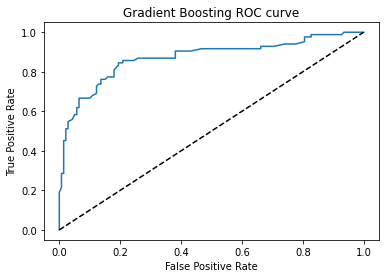

In [0]:
probs = clf.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC curve')
plt.show()

#**Logistic Regression With 81% Test Accuracy**

In [0]:
logreg = LogisticRegression(random_state=1,max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predictions = logreg.predict(X_train)
accuracy = accuracy_score(y_train, predictions)
print(np.round(accuracy*100, 2), '%')
predictions = logreg.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(np.round(accuracy*100, 2), '%')
print(confusion_matrix(y_test, predictions))
print("="*60)
print(classification_report(y_test, predictions))

79.49 %
81.17 %
[[119  20]
 [ 22  62]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       139
           1       0.76      0.74      0.75        84

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



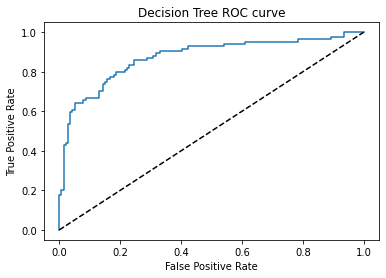

In [0]:
probs = logreg.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC curve')
plt.show()

In [0]:
dt = DecisionTreeClassifier(max_depth=4, random_state=1,max_features=8) 
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

#**Decision Tree With 83% Test Accuracy**

In [0]:
predictions = dt.predict(X_train)
accuracy = accuracy_score(y_train, predictions)
print(np.round(accuracy*100, 2), '%')
predictions = dt.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(np.round(accuracy*100, 2), '%')
print(confusion_matrix(y_test, predictions))
print("="*60)
print(classification_report(y_test, predictions))

83.23 %
83.41 %
[[132   7]
 [ 30  54]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       139
           1       0.89      0.64      0.74        84

    accuracy                           0.83       223
   macro avg       0.85      0.80      0.81       223
weighted avg       0.84      0.83      0.83       223



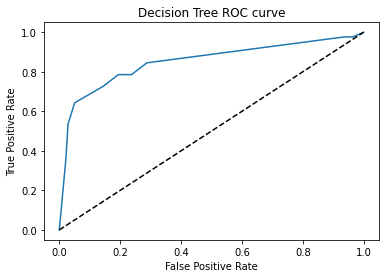

In [0]:
probs = dt.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC curve')
plt.show()